In [ ]:
#@title Colab Specifications

%matplotlib inline
%tensorflow_version 2.x

In [ ]:
#@title Mount at Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/cycleGAN')
print()
print(f"Current directory : {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Current directory : /content/drive/My Drive/Colab Notebooks/cycleGAN


In [3]:
#@title Data preprocessing

import tensorflow as tf
import tensorflow_datasets as tfds
from pathlib import Path

DATASET = "horse2zebra" #@param ["apple2orange", "summer2winter_yosemite", "horse2zebra", "monet2photo", "cezanne2photo", "ukiyoe2photo", "vangogh2photo", "maps", "cityscapes", "facades", "iphone2dslr_flower"] {allow-input: true}
TF_DATASET = 'cycle_gan/' + DATASET

# load dataset
tf_dataset, info = tfds.load(TF_DATASET, batch_size=-1, with_info=True)
np_dataset = tfds.as_numpy(tf_dataset)
train_A, train_B, test_A, test_B = np_dataset["trainA"]["image"] / 127.5 - 1., np_dataset["trainB"]["image"] / 127.5 - 1., np_dataset["testA"]["image"] / 127.5 - 1., np_dataset["testB"]["image"] / 127.5 - 1.
train_A, train_B, test_A, test_B = train_A.astype('float32'), train_B.astype('float32'), test_A.astype('float32'), test_B.astype('float32')

DIMS = train_A[0].shape
DATASET = DATASET.upper()

PATHS = [
         f'plots/{DATASET}/',
         f'models/{DATASET}/',
         f'logs/{DATASET}/',
         f'optimizers/{DATASET}/'  
          ]

for path in PATHS:
    Path(path).mkdir(parents=True, exist_ok=True)

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incomplete41RQO1/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incomplete41RQO1/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incomplete41RQO1/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incomplete41RQO1/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0. Subsequent calls will reuse this data.


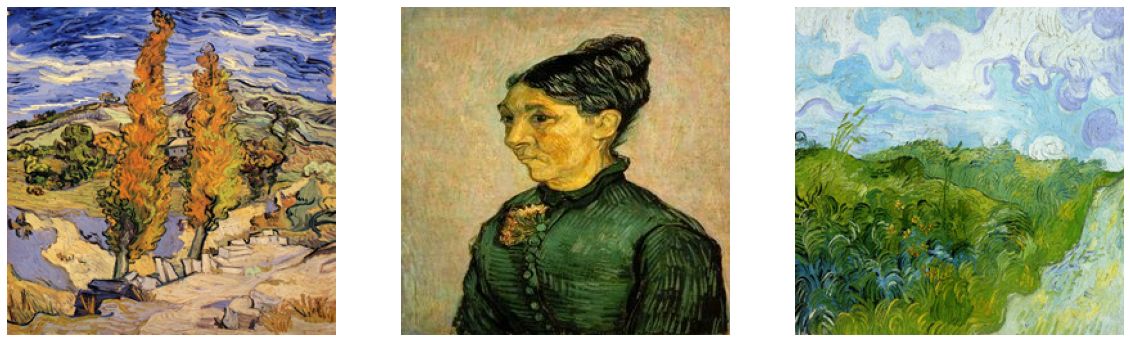

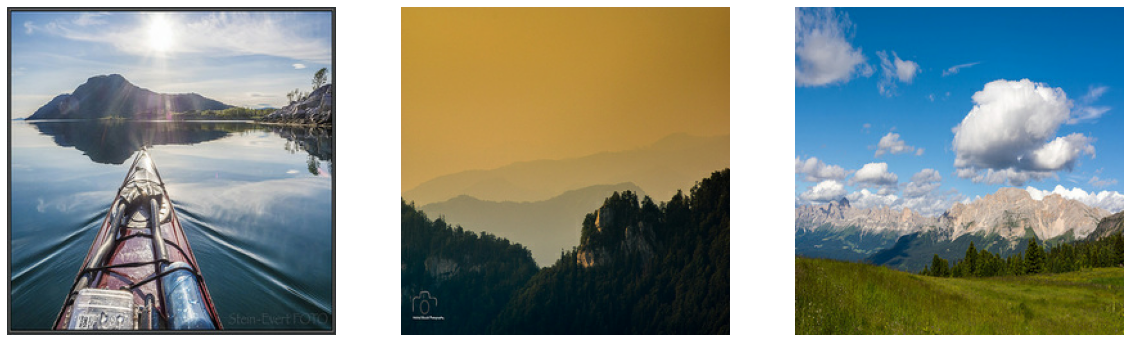

In [4]:
#@title Data Visualization

from matplotlib import pyplot
from pylab import rcParams

VIS_LINES = 1 #@param {type:"integer"}
VIS_ROWS = 3 #@param {type:"integer"}

PLOT_SIZE = 20 #@param {type:"integer"}

rcParams['figure.figsize'] = PLOT_SIZE, PLOT_SIZE

# plot images from domain A dataset
for i in range(VIS_LINES*VIS_ROWS):
    # define subplot
    pyplot.subplot(VIS_LINES, VIS_ROWS, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(tf.squeeze((train_A[i] + 1) / 2), cmap='gray_r')
pyplot.show()

# plot images from domain B dataset
for i in range(VIS_LINES*VIS_ROWS):
    # define subplot
    pyplot.subplot(VIS_LINES, VIS_ROWS, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(tf.squeeze((train_B[i] + 1) / 2), cmap='gray_r')
pyplot.show()

In [5]:
#@title Best cycleGAN Model

from tensorflow.keras.models import Sequential, Model
import numpy as np

class cycleGAN(Model):
    """
    Honestly, the best way to implement a model
    """

    def __init__(self, **kwargs):
        """
        initialize model with its super's features and methods
        """

        super(cycleGAN, self).__init__()
        self.__dict__.update(kwargs)

    @tf.function
    def A_to_B(self, x):
        """
        passes through the generator network
        """

        return self.gen_A_to_B(x)

    @tf.function
    def B_to_A(self, x):
        """
        passes through the generator network
        """

        return self.gen_B_to_A(x)

    @tf.function
    def discriminate_A(self, x):
        """
        passes through the discrimenator network
        """

        return self.disc_A(x)

    @tf.function
    def discriminate_B(self, x):
        """
        passes through the discrimenator network
        """

        return self.disc_B(x)

    @tf.function
    def compute_A_to_B_loss(self, real_a, real_b, batch_size=1):
        """
        passes through the network and computes loss
        """

        # forward cycle
        gen_b = self.A_to_B(real_a)
        forward_output = self.B_to_A(gen_b)
        # discriminator element
        discriminator_output = self.discriminate_B(gen_b)
        # backward cycle
        gen_a = self.B_to_A(real_b)
        backward_output = self.A_to_B(gen_a)
        # identity element
        identity_output = self.A_to_B(real_b)
        # calculate different losses
        discrimenator_loss = tf.reduce_mean(tf.keras.losses.MSE(
            discriminator_output, tf.ones(shape=discriminator_output.shape)))
        identity_loss = tf.reduce_mean(
            tf.keras.losses.MAE(identity_output, real_b))
        forward_loss = tf.reduce_mean(
            tf.keras.losses.MAE(forward_output,  real_a))
        backward_loss = tf.reduce_mean(
            tf.keras.losses.MAE(backward_output, real_b))
        # calculate final loss
        loss = 1.*discrimenator_loss + 5.*identity_loss + \
            10.*forward_loss + 10.*backward_loss

        return loss

    @tf.function
    def compute_B_to_A_loss(self, real_a, real_b, batch_size=1):
        """
        passes through the network and computes loss
        """

        # forward cycle
        gen_a = self.B_to_A(real_b)
        forward_output = self.A_to_B(gen_a)
        # discriminator element
        discriminator_output = self.discriminate_A(gen_a)
        # backward cycle
        gen_b = self.A_to_B(real_a)
        backward_output = self.B_to_A(gen_b)
        # identity element
        identity_output = self.B_to_A(real_a)
        # calculate different losses
        discrimenator_loss = tf.reduce_mean(tf.keras.losses.MSE(
            discriminator_output, tf.ones(shape=discriminator_output.shape)))
        identity_loss = tf.reduce_mean(
            tf.keras.losses.MAE(identity_output, real_a))
        forward_loss = tf.reduce_mean(
            tf.keras.losses.MAE(forward_output,  real_b))
        backward_loss = tf.reduce_mean(
            tf.keras.losses.MAE(backward_output, real_a))
        # calculate final loss
        loss = 1.*discrimenator_loss + 5.*identity_loss + \
            10.*forward_loss + 10.*backward_loss

        return loss

    @tf.function
    def compute_disc_A_loss(self, real_a, real_b, batch_size=1):
        """
        passes through the network and computes loss
        """

        # generate fake sample
        gen_a = self.B_to_A(real_b)
        gen_a = update_pool_A(gen_a)

        # discriminator element
        real_output = self.discriminate_A(real_a)
        fake_output = self.discriminate_A(gen_a)

        # calculate different losses
        real_loss = tf.reduce_mean(tf.keras.losses.MSE(
            real_output, tf.ones(shape=real_output.shape)))
        fake_loss = tf.reduce_mean(tf.keras.losses.MSE(
            fake_output, tf.zeros(shape=fake_output.shape)))

        # calculate final loss
        loss = .5*(real_loss + fake_loss)

        return loss

    @tf.function
    def compute_disc_B_loss(self, real_a, real_b, batch_size=1):
        """
        passes through the network and computes loss
        """
        # generate fake sample
        gen_b = self.A_to_B(real_a)
        gen_b = update_pool_B(gen_b)

        # discriminator element
        real_output = self.discriminate_B(real_b)
        fake_output = self.discriminate_B(gen_b)

        # calculate different losses
        real_loss = tf.reduce_mean(tf.keras.losses.MSE(
            real_output, tf.ones(shape=real_output.shape)))
        fake_loss = tf.reduce_mean(tf.keras.losses.MSE(
            fake_output, tf.zeros(shape=fake_output.shape)))

        # calculate final loss
        loss = .5*(real_loss + fake_loss)

        return loss

    @tf.function
    def compute_A_to_B_gradients(self, real_a, real_b, batch_size=1):
        """
        passes through the network and computes loss
        """

        # computation envirenment
        with tf.GradientTape() as A_to_B_tape:
            # compute loss
            A_to_B_loss = self.compute_A_to_B_loss(real_a, real_b, batch_size)
            # compute gradients
            A_to_B_gradients = A_to_B_tape.gradient(A_to_B_loss, self.gen_A_to_B.trainable_variables)

        return A_to_B_gradients, A_to_B_loss

    @tf.function
    def compute_B_to_A_gradients(self, real_a, real_b, batch_size=1):
        """
        passes through the network and computes loss
        """

        # computation envirenment
        with tf.GradientTape() as B_to_A_tape:
            # compute loss
            B_to_A_loss = self.compute_B_to_A_loss(real_a, real_b, batch_size)
            # compute gradients
            B_to_A_gradients = B_to_A_tape.gradient(B_to_A_loss, self.gen_B_to_A.trainable_variables)

        return B_to_A_gradients, B_to_A_loss

    @tf.function
    def compute_disc_A_gradients(self, real_a, real_b, batch_size=1):
        """
        passes through the network and computes loss
        """

        # computation envirenment
        with tf.GradientTape() as disc_A_tape:
            # compute loss
            disc_A_loss = self.compute_disc_A_loss(real_a, real_b, batch_size)
            # compute gradients
            disc_A_gradients = disc_A_tape.gradient(disc_A_loss, self.disc_A.trainable_variables)

        return disc_A_gradients, disc_A_loss

    @tf.function
    def compute_disc_B_gradients(self, real_a, real_b, batch_size=1):
        """
        passes through the network and computes loss
        """

        # computation envirenment
        with tf.GradientTape() as disc_B_tape:
            # compute loss
            disc_B_loss = self.compute_disc_B_loss(real_a, real_b, batch_size)
            # compute gradients
            disc_B_gradients = disc_B_tape.gradient(disc_B_loss, self.disc_B.trainable_variables)

        return disc_B_gradients, disc_B_loss

    @tf.function
    def train_A_to_B(self, real_a, real_b, batch_size=1):

        # calculate gradients and loss
        A_to_B_gradients, A_to_B_loss = self.compute_A_to_B_gradients(
            real_a, real_b, batch_size)
        # apply gradients
        self.gen_A_to_B_optimizer.apply_gradients(
            zip(A_to_B_gradients, self.gen_A_to_B.trainable_variables))

        return A_to_B_loss

    @tf.function
    def train_B_to_A(self, real_a, real_b, batch_size=1):

        # calculate gradients and loss
        B_to_A_gradients, B_to_A_loss = self.compute_B_to_A_gradients(real_a, real_b, batch_size)
        # apply gradients
        self.gen_B_to_A_optimizer.apply_gradients(zip(B_to_A_gradients, self.gen_B_to_A.trainable_variables))

        return B_to_A_loss

    @tf.function
    def train_disc_A(self, real_a, real_b, batch_size=1):

        # calculate gradients and loss
        disc_A_gradients, disc_A_loss = self.compute_disc_A_gradients(
            real_a, real_b, batch_size)
        # apply gradients
        self.disc_A_optimizer.apply_gradients(zip(disc_A_gradients, self.disc_A.trainable_variables))

        return disc_A_loss

    @tf.function
    def train_disc_B(self, real_a, real_b, batch_size=1):

        # calculate gradients and loss
        disc_B_gradients, disc_B_loss = self.compute_disc_B_gradients(
            real_a, real_b, batch_size)
        # apply gradients
        self.disc_B_optimizer.apply_gradients(
            zip(disc_B_gradients, self.disc_B.trainable_variables))

        return disc_B_loss



In [6]:
#@title Defining the Generator and the Discrimenator sub-models

from tensorflow.keras.layers import Concatenate, Conv2D, Conv2DTranspose,     \
                                    Activation, Input, Dense,                 \
                                    Reshape, Flatten, Dropout, LeakyReLU

from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.initializers import RandomNormal

LOAD_MODEL = False #@param {type:"boolean"}
LOAD_EPOCH =  0#@param {type:"number"}
N_RESNET = 9 #@param {type:"number"}


# weight initialization
init = RandomNormal(stddev=0.02)

# define the discriminator model
def define_discriminator(image_shape):
    # source image input
    input_image = Input(shape=image_shape)
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(input_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    # define model
    model = Model(input_image, patch_out)
    return model

# generator a resnet block
def resnet_block(input_layer, n_filters):
    # first layer convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    return g

# define the standalone generator model
def define_generator(image_shape, n_resnet=N_RESNET):
    # image input
    input_image = Input(shape=image_shape)
    # c7s1-64
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(input_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d128
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d256
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # R256
    for i in range(n_resnet):
        g = resnet_block(g, 256)
    # u128
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # u64
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # c7s1-3
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    output_image = Activation('tanh')(g)
    # define model
    model = Model(input_image, output_image)
    return model


In [7]:
#@title Build and compile the model with its optimizers

from tensorflow.keras.optimizers import Adam

ALPHA = 0.0002 #@param {type:"number"}
BETA_1 = 0.5 #@param {type:"number"}

# optimizers
gen_A_to_B_optimizer = Adam(lr=ALPHA, beta_1=BETA_1)
gen_B_to_A_optimizer = Adam(lr=ALPHA, beta_1=BETA_1)
disc_A_optimizer = Adam(lr=ALPHA, beta_1=BETA_1)
disc_B_optimizer = Adam(lr=ALPHA, beta_1=BETA_1)

if LOAD_MODEL:

    # load optimizers
    # Get saved weights
    gen_A_to_B_optimizer_weights = np.load(f'optimizers/{DATASET}/cycleGAN_e{LOAD_EPOCH:03}_gen_A_to_B.npy', allow_pickle=True)
    gen_B_to_A_optimizer_weights = np.load(f'optimizers/{DATASET}/cycleGAN_e{LOAD_EPOCH:03}_gen_B_to_A.npy', allow_pickle=True)
    disc_A_optimizer_weights     = np.load(f'optimizers/{DATASET}/cycleGAN_e{LOAD_EPOCH:03}_disc_A.npy', allow_pickle=True)
    disc_B_optimizer_weights     = np.load(f'optimizers/{DATASET}/cycleGAN_e{LOAD_EPOCH:03}_disc_B.npy', allow_pickle=True)

    # load models
    gen_A_to_B = tf.keras.models.load_model(f'models/{DATASET}/cycleGAN_e{LOAD_EPOCH:03}_gen_A_to_B.tf')
    gen_B_to_A = tf.keras.models.load_model(f'models/{DATASET}/cycleGAN_e{LOAD_EPOCH:03}_gen_B_to_A.tf')
    disc_A = tf.keras.models.load_model(f'models/{DATASET}/cycleGAN_e{LOAD_EPOCH:03}_disc_A.tf')
    disc_B = tf.keras.models.load_model(f'models/{DATASET}/cycleGAN_e{LOAD_EPOCH:03}_disc_B.tf')

    # get variables
    gen_A_to_B_vars              = gen_A_to_B.trainable_weights
    gen_B_to_A_vars              = gen_B_to_A.trainable_weights
    disc_A_vars                  = disc_A.trainable_weights
    disc_B_vars                  = disc_B.trainable_weights

    gen_A_to_B_zeros              = [tf.zeros_like(w) for w in gen_A_to_B_vars]
    gen_B_to_A_zeros              = [tf.zeros_like(w) for w in gen_B_to_A_vars]
    disc_A_zeros                  = [tf.zeros_like(w) for w in disc_A_vars]
    disc_B_zeros                  = [tf.zeros_like(w) for w in disc_B_vars]

    # Apply gradients which don't do nothing with Adam
    gen_A_to_B_optimizer.apply_gradients(zip(gen_A_to_B_zeros, gen_A_to_B_vars))
    gen_B_to_A_optimizer.apply_gradients(zip(gen_B_to_A_zeros, gen_B_to_A_vars))
    disc_A_optimizer.apply_gradients(zip(disc_A_zeros, disc_A_vars))
    disc_B_optimizer.apply_gradients(zip(disc_B_zeros, disc_B_vars))

    # Set the weights of the optimizer
    gen_A_to_B_optimizer.set_weights(gen_A_to_B_optimizer_weights)
    gen_B_to_A_optimizer.set_weights(gen_B_to_A_optimizer_weights)
    disc_A_optimizer.set_weights(disc_A_optimizer_weights)
    disc_B_optimizer.set_weights(disc_B_optimizer_weights)

    # load models
    gen_A_to_B = tf.keras.models.load_model(f'models/{DATASET}/cycleGAN_e{LOAD_EPOCH:03}_gen_A_to_B.tf')
    gen_B_to_A = tf.keras.models.load_model(f'models/{DATASET}/cycleGAN_e{LOAD_EPOCH:03}_gen_B_to_A.tf')
    disc_A = tf.keras.models.load_model(f'models/{DATASET}/cycleGAN_e{LOAD_EPOCH:03}_disc_A.tf')
    disc_B = tf.keras.models.load_model(f'models/{DATASET}/cycleGAN_e{LOAD_EPOCH:03}_disc_B.tf')

else:
    # generators
    # generator: A -> B
    gen_A_to_B = define_generator(DIMS)
    # generator: B -> A
    gen_B_to_A = define_generator(DIMS)

    # discriminators
    # discriminator: A -> [real/fake]
    disc_A = define_discriminator(DIMS)
    # discriminator: B -> [real/fake]
    disc_B = define_discriminator(DIMS)

# model
model = cycleGAN(name=f'cycleGAN_{DATASET}',
                 disc_A = disc_A,
                 disc_B = disc_B,
                 gen_A_to_B = gen_A_to_B,
                 gen_B_to_A = gen_B_to_A,
                 disc_A_optimizer = disc_A_optimizer,
                 disc_B_optimizer = disc_B_optimizer,
                 gen_A_to_B_optimizer = gen_A_to_B_optimizer,
                 gen_B_to_A_optimizer = gen_B_to_A_optimizer,
                 )


FileNotFoundError: ignored

In [ ]:
#@title Third party functions for saving model and plots

from IPython.display import clear_output
import numpy as np

N_SAMPLES = 3 #@param {type:"integer"}

# evaluate the discrimenator, plot generated images, save generator model
def summarize_performance(epoch, model, test_A, test_B, losses):
    # a simple summerizing print
    print(f"Epoch: {epoch+1} | A_to_B_loss: {losses.A_to_B_loss.values[-1]} | B_to_A_loss: {losses.B_to_A_loss.values[-1]}")
    # save plot
    save_plot(epoch, model.A_to_B, test_A, 'A_to_B')
    save_plot(epoch, model.B_to_A, test_B, 'B_to_A')
    # save history
    save_history(losses)
    # save the model
    save_model(epoch, model.disc_A, 'disc_A')
    save_model(epoch, model.disc_B, 'disc_B')
    save_model(epoch, model.gen_A_to_B, 'gen_A_to_B')
    save_model(epoch, model.gen_B_to_A, 'gen_B_to_A')
    save_optimizer(epoch, disc_A_optimizer, 'disc_A')
    save_optimizer(epoch, disc_B_optimizer, 'disc_B')
    save_optimizer(epoch, gen_A_to_B_optimizer, 'gen_A_to_B')
    save_optimizer(epoch, gen_B_to_A_optimizer, 'gen_B_to_A')

# create and save a plot of generated images
def save_plot(epoch, model, test_X, domains, n_samples=N_SAMPLES):
    # choose random images from dataset
    ix = np.random.randint(0, len(test_X), n_samples)
    test_x = test_X[ix]
    # generte trasfered images
    gen_x = model(test_x)
    # scale from [-1,1] to [0,1]
    test_x = (test_x + 1.) / 2.
    gen_x = (gen_x + 1.) / 2.
    # plot real images
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(test_x[i])
    # plot translated image
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(gen_x[i])
    # save plot to file
    file_name = f'plots/{DATASET}/cycleGAN_e{epoch+1:03}_{domains}.png'
    pyplot.savefig(file_name)
    # pyplot.show()
    pyplot.close()

# save the whole model if possible xD
def save_model(epoch, model, component):
    file_name = f'models/{DATASET}/cycleGAN_e{epoch+1:03}_{component}.tf'
    model.save(file_name)

def save_optimizer(epoch, optimizer, component):
    file_name = f'optimizers/{DATASET}/cycleGAN_e{epoch+1:03}_{component}'
    np.save(file_name, optimizer.get_weights())

def save_history(losses):
    # plot history
    pyplot.plot(losses.A_to_B_loss.values, label='A_to_B_loss')
    pyplot.plot(losses.B_to_A_loss.values, label='B_to_A_loss')
    pyplot.legend()
    file_name = f'plots/{DATASET}/cycleGAN_loss_history.png'
    pyplot.savefig(file_name)
    pyplot.close()

def update_pool_A(image, max_size=50):
    selected = list()

    if len(pool_A) < max_size:
        # stock the pool
        pool_A.append(image)
        selected.append(image)
    elif np.random.random() < 0.5:
        # use image, but don't add it to the pool
        selected.append(image)
    else:
        # replace an existing image and use replaced image
        ix = np.random.randint(0, len(pool_A))
        selected.append(pool_A[ix])
        pool_A[ix] = image

    return selected

def update_pool_B(image, max_size=50):
    selected = list()

    if len(pool_B) < max_size:
        # stock the pool
        pool_B.append(image)
        selected.append(image)
    elif np.random.random() < 0.5:
        # use image, but don't add it to the pool
        selected.append(image)
    else:
        # replace an existing image and use replaced image
        ix = np.random.randint(0, len(pool_B))
        selected.append(pool_B[ix])
        pool_B[ix] = image
    
    return selected

In [ ]:
#@title Start training

from tqdm import tqdm
from pandas import DataFrame

if LOAD_MODEL:
    START_EPOCH = LOAD_EPOCH
else:
    START_EPOCH = 0

END_EPOCH = 100  # @param {type:"integer"}
BATCH_SIZE = 1  # @param {type:"integer"}


TRAIN_A_BUF = len(train_A)
TRAIN_B_BUF = len(train_B)
TRAIN_BUF = min([TRAIN_A_BUF, TRAIN_B_BUF])
TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)

# a pandas dataframe to save the loss information to
losses = DataFrame(columns = ['A_to_B_loss', 'B_to_A_loss'])
losses.loc[len(losses)] = (0, 0)
summarize_performance(START_EPOCH-1, model, train_A, train_B, losses)

pool_A, pool_B = [], []

# iterate through epochs
for i in range(START_EPOCH, END_EPOCH+1):
    # initiate loss counter
    loss = []
    # enumerate batches over the training set
    for j in tqdm(range(TRAIN_BATCHES)):
        # take random indexes
        ia = np.random.randint(0, TRAIN_A_BUF, BATCH_SIZE)
        ib = np.random.randint(0, TRAIN_B_BUF, BATCH_SIZE)
        # select images
        real_a = train_A[ia]
        real_b = train_B[ib]
        # update generator B->A via adversarial and cycle loss
        B_to_A_loss = model.train_B_to_A(real_a, real_b)
        # update discriminator for A -> [real/fake]
        disc_A_loss = model.train_disc_A(real_a, real_b)
        # update generator A->B via adversarial and cycle loss
        A_to_B_loss = model.train_A_to_B(real_a, real_b)
        # update discriminator for B -> [real/fake]
        disc_B_loss = model.train_disc_B(real_a, real_b)
        # save batch loss
        loss.append((A_to_B_loss, B_to_A_loss))
    # average loss over epoch
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # clear previous results
    clear_output()
    # evaluate the model performance, sometimes
    summarize_performance(i, model, train_A, train_B, losses)